In [1]:
from pycocotools.coco import COCO
import numpy as np


In [2]:
dataDir='../NN/detectron2/datasets/coco'
dataType='train2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)
imgDir = '{}/{}/'.format(dataDir, dataType)

In [3]:
coco=COCO(annFile)

loading annotations into memory...
Done (t=9.56s)
creating index...
index created!


In [4]:
catCatID = coco.getCatIds(catNms='cat')
catImgID = coco.getImgIds(catIds=catCatID)
catAnnID = coco.getAnnIds(catIds=catCatID)


In [5]:
cats = coco.loadCats(ids=catCatID)
# imgs = coco.loadImgs(ids=catImgID)
catAnns = coco.loadAnns(ids=catAnnID)

print(len(cats), len(catAnns))

1 4768


In [6]:
import os
datasetDir = '/mnt/p/datasets/animals10/raw-img/'
negs = os.listdir(datasetDir + 'hairs/')
negFiles = iter(negs)


In [7]:
from collections import defaultdict
imgAnns = defaultdict(list)
for ann in catAnns:
    imgAnns[ann['image_id']].append(ann)
print(imgAnns.keys())


 55468, 34389, 191156, 163715, 113649, 219194, 384678, 236028, 350727, 499054, 122196, 186483, 401060, 549605, 473964, 456376, 549231, 431060, 372709, 414189, 390518, 75810, 130047, 123970, 97311, 188459, 484734, 285699, 140155, 227245, 262727, 577320, 457560, 374561, 380905, 282002, 578072, 426731, 71792, 152812, 412929, 179034, 576111, 382441, 364244, 175202, 360719, 99108, 365205, 1319, 523536, 475998, 369796, 537444, 387295, 379799, 555811, 510235, 276507, 420344, 251246, 367471, 104510, 48993, 539101, 31090, 389541, 229228, 248133, 75084, 410704, 14804, 197236, 326313, 46024, 196393, 366787, 87232, 280866, 19987, 359772, 328858, 280235, 137238, 548240, 175383, 560189, 316089, 92729, 451381, 235759, 155707, 31865, 457384, 57362, 395155, 308739, 575923, 189069, 446604, 136917, 258305, 491873, 378832, 174527, 407139, 393432, 322121, 394234, 376772, 283456, 81639, 559490, 483928, 233379, 403162, 348199, 185124, 114657, 301549, 132294, 89973, 220408, 436214, 180168, 548511, 67126, 5336

In [8]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
import random


imgs = []
i = 0
max_width = 0
for image_id, anns in imgAnns.items():
    bboxes = [list(map(int, ann['bbox'])) for ann in anns]

    vis = np.zeros((5, 5, 3), np.uint8)
    try:
        # Cat
        imgc = "{:012d}.jpg".format(image_id)
        img = cv2.imread(imgDir + imgc)
        # Negative sample
        neg = datasetDir + 'hairs/' + next(negFiles)
        neg_img = cv2.imread(neg)
        # Sizes
        h1, w1 = img.shape[0],img.shape[1]
        h2, w2 = neg_img.shape[0],neg_img.shape[1]
        # Resize images
        if h1 > h2:
            neg_img = cv2.resize(neg_img, (w2*h1//h2, h1))
            h2, w2 = neg_img.shape[0],neg_img.shape[1]
        else:
            img = cv2.resize(img, (w1*h2//h1, h2))
            bboxes = [list(map(lambda x: x*h2//h1, bbox)) for bbox in bboxes]
            h1, w1 = img.shape[0],img.shape[1]
        # New image
        vis = np.zeros((max(h1, h2), w1+w2, 3), np.uint8)

        if random.randint(0, 1) == 0:
            # Insert negative sample to right
            vis[0:h1,0:w1] = img
            vis[0:h2, w1:w1+w2] = neg_img
        else:
            # Insert negative sample to left
            vis[0:h2,0:w2] = neg_img
            vis[0:h1, w2:w2+w1] = img
            # Shift bbox
            for bbox in bboxes:
                bbox[0] += w2
        # Resize image
        h, w = vis.shape[0], vis.shape[1]
        MAX_HEIGHT = 800
        if h > MAX_HEIGHT:
            bboxes = [list(map(lambda x: x*MAX_HEIGHT//h, bbox)) for bbox in bboxes]
            vis = cv2.resize(vis, (w*MAX_HEIGHT//h, MAX_HEIGHT))

    except StopIteration:
        print('END!')
        negFiles = iter(negs)
        continue
    # Update bboxes in annotations
    for (ann, bbox) in zip(anns, bboxes):
        ann['bbox'] = bbox
    # add img to dataset
    imgs.append({
        "id": image_id,
        "width": vis.shape[1],
        "height": vis.shape[0],
        "file_name": str(image_id) + '.jpg',
    })
    if vis.shape[1] > max_width:
        max_width = vis.shape[1]
    # save img
    cv2.imwrite(datasetDir + 'cats_with_neg/' + str(image_id) + '.jpg', vis) 
    # for ann in anns:
    #     bbox = ann['bbox']
    #     cv2.rectangle(vis, (bbox[0], bbox[1]), (bbox[0]+bbox[2], bbox[1]+bbox[3]), (0, 0, 250), thickness = 10)

    # img2 = vis[:,:,::-1]
    # plt.figure()
    # plt.imshow(img2)
    i += 1
    if i % 200 == 0:
        print(int(i / len(imgAnns) * 100))
print('max width', max_width)


4
9
14
19
24
29
34
38
43
48
53
58
63
68
72
77
82
87
92
97
max width 3106


In [9]:
anotation = {
    "images": imgs,
    "annotations": catAnns,
    "categories": cats,
    "licenses": []
}

In [10]:
import json

with open("cats_detection_neg_samp.json", "w+") as a:
    a.write(json.dumps(anotation))

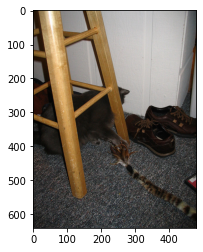

In [11]:



neg_img = cv2.resize(cv2.imread(neg), (250, 250))

x_offset=y_offset=50
# img[y_offset:y_offset+neg_img.shape[0], x_offset:x_offset+neg_img.shape[1]] = neg_img

cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[0]+bbox[2], bbox[1]+bbox[3]), (0, 0, 250))

img2 = img[:,:,::-1]
plt.imshow(img2)

In [12]:
cats

[{'supercategory': 'animal', 'id': 17, 'name': 'cat'}]